# Investigating Effect of Entanglement on Virtualization's Fidelity

In this notebook, we test out the hypothesis that the performance of a virtualized circuit deteriorate with the increasing amount of entanglement between the two fragments of the cut two-qubit gate.

The measure of entanglement in this experiment is "entanglement of formation", which is a measure of the entanglement between two qubits. Thus, our experiments will be limited to two-qubit circuits only.

The following parameters will be tried out for this experiment:
- Exact virtualization of the CNOT gate.
- Approximate virtualization of the CNOT gate.

For the setup of the experiment, we build a Bell-state preparation circuit where a qubit in superposition is entangled with another using a CNOT. The superposition is parameterized, and is controlled by an RY gate followed by an RX gate.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from itertools import product
from pprint import pprint

from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
from qiskit.quantum_info import Statevector, entanglement_of_formation

import vqc
from vqc.benchmarking.fidelity import fidelity
from vqc.cutting import KernighanLinBisection
from vqc.cutting.cut import STANDARD_VIRTUAL_GATES, STANDARD_APPROX_VIRTUAL_GATES
from vqc.executor import Simulator

Let's first perform a 2D-sweep along different values of RY and RX rotation to see how the entanglement changes.

In [3]:
resolution = 50
rx_vals = np.linspace(0, np.pi, resolution)
ry_vals = np.linspace(0, np.pi, resolution)

In [4]:
def circ():
    ry_parameter = Parameter('ry_theta')
    rx_parameter = Parameter('rx_theta')
    qc = QuantumCircuit(2, 2)
    qc.ry(theta=ry_parameter, qubit=0)
    qc.rx(theta=rx_parameter, qubit=0)
    qc.cnot(0, 1)
    qc.measure(qubit=[0, 1], cbit=[0, 1])

    return qc, rx_parameter, ry_parameter

In [5]:
qc, rx_param, ry_param = circ()
print(qc)

     ┌──────────────┐┌──────────────┐     ┌─┐   
q_0: ┤ Ry(ry_theta) ├┤ Rx(rx_theta) ├──■──┤M├───
     └──────────────┘└──────────────┘┌─┴─┐└╥┘┌─┐
q_1: ────────────────────────────────┤ X ├─╫─┤M├
                                     └───┘ ║ └╥┘
c: 2/══════════════════════════════════════╩══╩═
                                           0  1 


In [6]:
grid_results = {}
qc_no_meas = qc.remove_final_measurements(inplace=False)
for rx_angle, ry_angle in product(rx_vals, ry_vals):
    curr_qc = qc_no_meas.bind_parameters({rx_param: rx_angle, ry_param: ry_angle})
    sv = Statevector.from_instruction(curr_qc)

    grid_results[(rx_angle, ry_angle)] = entanglement_of_formation(sv)

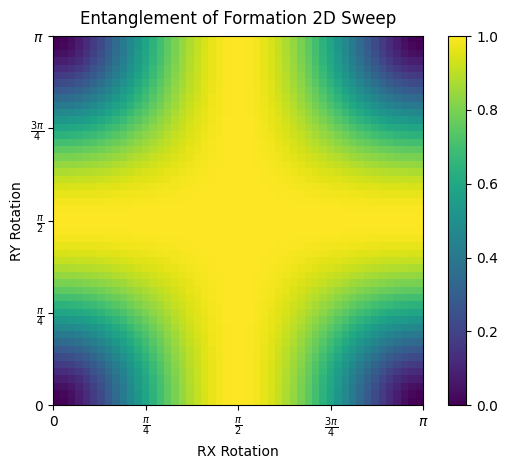

In [7]:
ent = np.array(list(grid_results.values()))

fig, ax = plt.subplots()
ax_ = ax.imshow(
    ent.reshape(resolution, resolution),
    origin="lower",
    vmin=0,
    vmax=1,
    extent=(0, np.pi, 0, np.pi),
)
fig.colorbar(ax_)
ax.set_xticks([0, 0.25 * np.pi, 0.5 * np.pi, 0.75 * np.pi, np.pi])
ax.set_xticklabels([r'$0$', r'$\frac{\pi}{4}$', r'$\frac{\pi}{2}$', r'$\frac{3 \pi}{4}$', r'$\pi$'])
ax.set_yticks([0, 0.25 * np.pi, 0.5 * np.pi, 0.75 * np.pi, np.pi])
ax.set_yticklabels([r'$0$', r'$\frac{\pi}{4}$', r'$\frac{\pi}{2}$', r'$\frac{3 \pi}{4}$', r'$\pi$'])

plt.title("Entanglement of Formation 2D Sweep", y=1.01)
plt.xlabel("RX Rotation")
plt.ylabel("RY Rotation")

plt.show()

It seems that we achieve maximum entanglement within one quadrant, so we can limit the domain of our experiment (i.e. the rotation angles) to $$x,y \in [0, \frac{\pi}{2}]$$

In [8]:
rx_vals = rx_vals[:resolution // 2]
ry_vals = ry_vals[:resolution // 2]

In [9]:
exact_virt_circuit = vqc.cutting.cut(qc, KernighanLinBisection(vgates=STANDARD_VIRTUAL_GATES))
exact_knitter = vqc.Knitter(exact_virt_circuit)
exact_samples = exact_knitter.samples()
pprint(exact_samples)

{'frag0': [<qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x7f09d300a560>,
 'frag1': [<qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x7f09d3013220>,
           <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x7f09d2ee7ac0>]}


In [10]:
approx_virt_circuit = vqc.cutting.cut(qc, KernighanLinBisection(vgates=STANDARD_APPROX_VIRTUAL_GATES))
approx_knitter = vqc.Knitter(approx_virt_circuit)
approx_samples = approx_knitter.samples()
pprint(approx_samples)

{'frag0': [<qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x7f0a1c59bc10>,
 'frag1': [<qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x7f09d300bbe0>,
           <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x7f09d2ee6350>]}


In [11]:
sim = Simulator()

exact_fidelity_results = {}
approx_fidelity_results = {}
for rx_angle, ry_angle in tqdm(zip(rx_vals, ry_vals), total=len(rx_vals)):
    bound_original_qc = qc.bind_parameters({rx_param: rx_angle, ry_param: ry_angle})

    exact_results = sim.execute(exact_samples, {rx_param: rx_angle, ry_param: ry_angle})
    exact_prob_distr = exact_knitter.knit(exact_results)
    exact_fidelity_results[(rx_angle, ry_angle)] = fidelity(
        bound_original_qc,
        exact_prob_distr.counts(10000),
    )

    approx_results = sim.execute(approx_samples, {rx_param: rx_angle, ry_param: ry_angle})
    approx_prob_distr = approx_knitter.knit(approx_results)
    approx_fidelity_results[(rx_angle, ry_angle)] = fidelity(
        bound_original_qc,
        approx_prob_distr.counts(10000),
    )

100%|██████████| 25/25 [00:23<00:00,  1.05it/s]


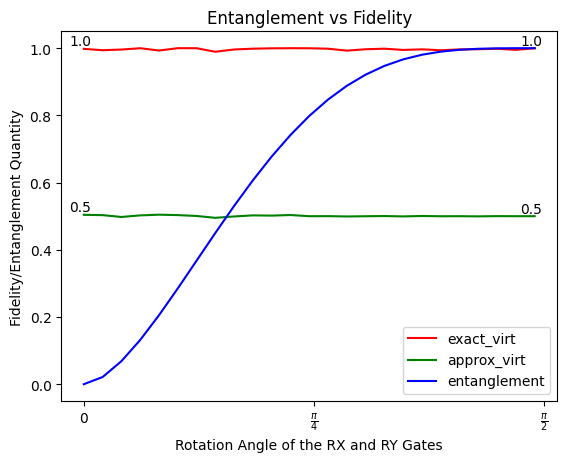

In [13]:
exact_values_list = list(exact_fidelity_results.values())
approx_values_list = list(approx_fidelity_results.values())
fig, ax = plt.subplots()

ax.set_xticks([0, 0.25 * np.pi, 0.5 * np.pi, 0.75 * np.pi, np.pi])
ax.set_xticklabels([r'$0$', r'$\frac{\pi}{4}$', r'$\frac{\pi}{2}$', r'$\frac{3 \pi}{4}$', r'$\pi$'])

ax.plot(rx_vals, exact_values_list, color='r', label='exact_virt')
ax.plot(rx_vals, approx_values_list, color='g', label='approx_virt')

ax.plot(rx_vals, [grid_results[(ang, ang)] for ang in rx_vals], color='b', label='entanglement')

ax.text(rx_vals[0] - 0.05, exact_values_list[0] + 0.01, round(exact_values_list[0], 2))
ax.text(rx_vals[-1] - 0.05, exact_values_list[-1] + 0.01, round(exact_values_list[-1], 2))

ax.text(rx_vals[0] - 0.05, approx_values_list[0] + 0.01, round(approx_values_list[0], 2))
ax.text(rx_vals[-1] - 0.05, approx_values_list[-1] + 0.01, round(approx_values_list[-1], 2))

plt.xlabel("Rotation Angle of the RX and RY Gates")
plt.ylabel("Fidelity/Entanglement Quantity")
plt.title("Entanglement vs Fidelity")
  
plt.legend()